# **CNS 2023 Tutorial:  Guide to Reconstructing Dynamical Systems from Neural Measurements Using Recurrent Neural Network**
## Complementary Hands-On Notebook

## About

In this notebook we will explore some of the concepts and techniques discussed in the tutorial and apply them to the common Lorenz63 benchmark system. Specifically, we will first implement the shallowPLRNN model, which we will use to learn a surrogate dynamical model of the chaotic Lorenz63 attractor. We will visualize the results, inspect the reconstruction via specific measures and compare the invariants of the system, such as the maximum Lyapunov exponent to the ground truth one, as well as computing the fixed points of the system.

While we believe that data preprocessing is one of the most important aspects of applying any machine learning model, the right preprocessing pipeline generally depends on the specific data at hand - in our experience this is even more so for dynamical systems reconstruction from empirical data! Nevertheless, the notebook is designed such that in principle you just need to put your empirical time series data into the correct shape and you should be able to train a model right away using this notebook - if you wish so. However, be aware that training might take some time, as this notebook provides a minimal working example with basically no runtime optimization. Moreover, often one needs to perform a reasonable grid search across hyperparameters to get decent results.

If this tutorial motivated you to dive a bit deeper in dynamical systems reconstruction, especially using our methods, we gladly refer to our other repositories, which provide e.g. a fast Julia implementation: https://github.com/DurstewitzLab/GTF-shPLRNN.

## 1 Preliminaries: Libraries & Fetching data
The code is mainly based on Pytorch. For colab, we will download the data `lorenz-datasets.zip`, which holds training & test data as well as a pretrained model. If you are executing the notebook locally, please make sure you clone the github repository and extract the content of `lorenz-datasets.zip`.

In [1]:
import torch
import torch.nn as nn
from torch.nn.init import uniform_
from random import randint
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import os

In [2]:
# load the data from the repository - only execute when using google colab
if not os.path.exists("lorenz-datasets.zip"):
  !wget https://github.com/DurstewitzLab/CNS-2023/raw/main/lorenz-datasets.zip
!unzip -o lorenz-datasets.zip
!ls

Archive:  lorenz-datasets.zip
  inflating: lorenz63_standardized_FPs.npy  
  inflating: lorenz63_test.npy       
  inflating: lorenz63_train.npy      
  inflating: pretrained-shPLRNN.pt   
lorenz63_standardized_FPs.npy  lorenz-datasets.zip    shallowPLRNN.pt
lorenz63_test.npy	       pretrained-shPLRNN.pt
lorenz63_train.npy	       sample_data


## 2 The data

The Lorenz63 system is a set of ordinary differential equations first studied by Edward Lorenz. It is notable for having chaotic solutions for certain parameter values and initial conditions. In particular, the Lorenz system is a simplified mathematical model for atmospheric convection. The system is defined by three state variables:

1. $x$ : The intensity of convective motion (or the rate of convection)
2. $y$ : The temperature difference between the ascending and descending currents
3. $z$ : The deviation of vertical temperature profile from linearity

The three coupled, first-order, nonlinear differential equations are:

1. $\frac{dx}{dt} = \sigma (y - x)$
2. $\frac{dy}{dt} = x(\rho - z) - y$
3. $\frac{dz}{dt} = xy - \beta z$

Where $\sigma$, $\rho$, and $\beta$ are parameters which represent the Prandtl number, Rayleigh number, and certain geometric factors, respectively. Here, we will use the standard parameters $\sigma=10$, $\rho=28$, and $\beta=\frac{8}{3}$. Using these settings, the Lorenz63 system exhibits multistability consisting of the famous chaotic butterfly attractor, as well as three unstable fixed points given by $\textrm{FP}_\pm = [\pm\sqrt{\beta(\rho-1)}, \pm\sqrt{\beta(\rho-1)}, \rho-1]$ inside the lobes and one at the origin. The maximum Lyapunov exponent of the chaotic attractor is $\lambda_{max} = 0.906$.

Let's load the Lorenz63 data and inspect the attractor.
The data consists of a training set and a test set. Both the train and test set are a single, long trajectory of the Lorenz63 system, started from two different, random initial conditions. The data is sampled using $\Delta t = 0.01$. In both cases, we discarded the transients such that the data only consists of the attractor. For training, we then standardize each dynamical variable to zero mean and unit variance. The training data is additionally contaminated with 5% Gaussian white noise. The data format is in $T \times N$, where $T$ is the number of available time points and $N$ is the number of dynamical variables. We assume we observe the entire system, hence $N=3$ for the Lorenz63 system. I.e. note that for simplicity, we assume that we only observed a single trajectory of the system of interest, but in principle this method can be used to learn a surrogate model from multiple trajectories.

[HINT: If you bring your own data, standardize it. Make sure your data is a numpy array/matrix of dimension $T \times N$.]

In [3]:
X_train = np.load("lorenz63_train.npy").astype(np.float32)
X_test = np.load("lorenz63_test.npy").astype(np.float32)
T_train, N = X_train.shape
T_test = X_test.shape[0]
X_train.shape, X_test.shape

((100000, 3), (100000, 3))

In [4]:
# load your external inputs here, they should be in a .npy file and of shape T x K
# S = np.load("...").astype(np.float32)

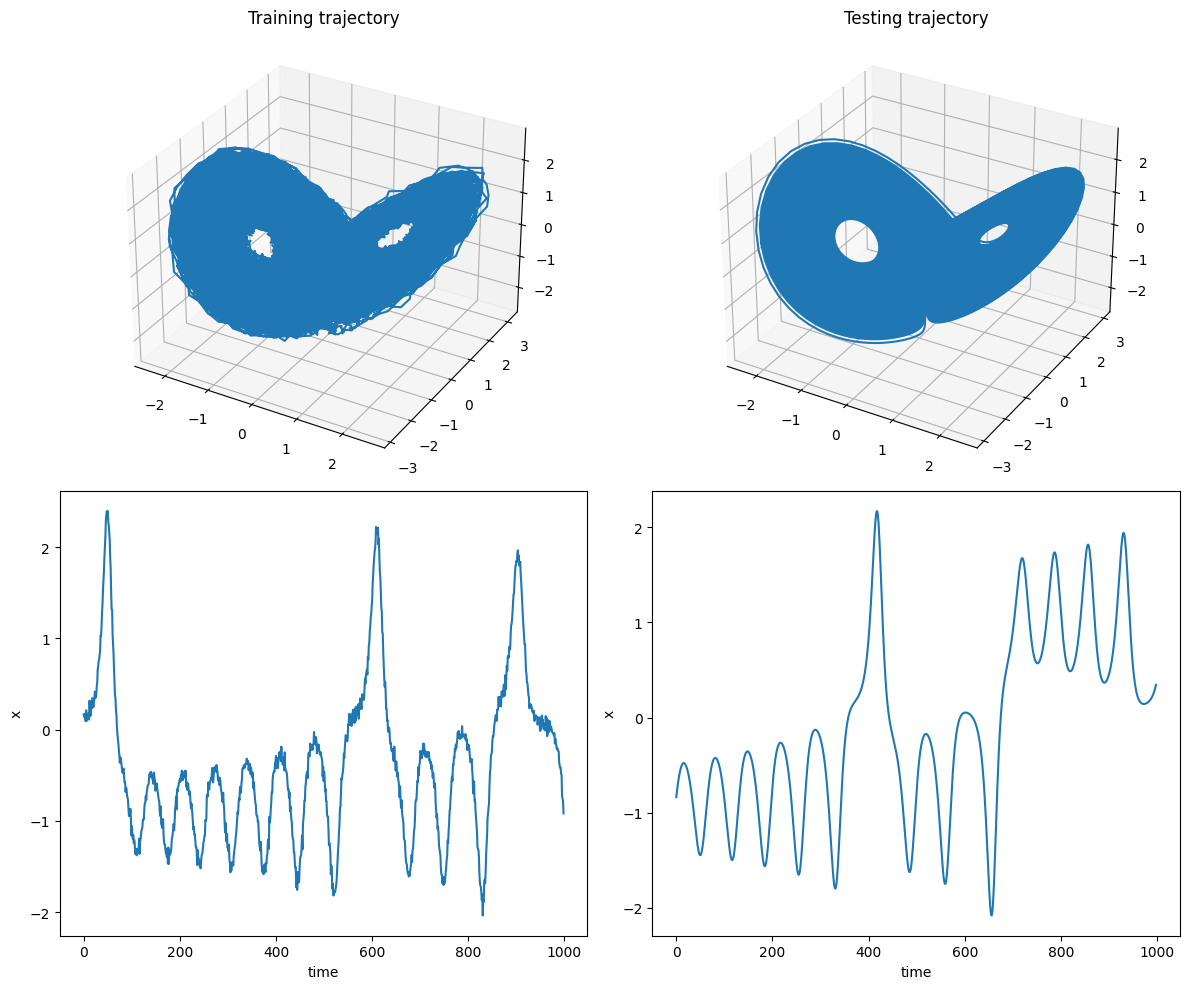

In [5]:
# visualize
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(221, projection='3d')
ax1.plot3D(X_train[:, 0], X_train[:, 1], X_train[:, 2])
ax1.set_title('Training trajectory')

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot3D(X_test[:, 0], X_test[:, 1], X_test[:, 2])
ax2.set_title('Testing trajectory')

ax3 = fig.add_subplot(223)
ax3.plot(X_train[1:1000, 0])
ax3.set_xlabel("time")
ax3.set_ylabel("x")

ax4 = fig.add_subplot(224)
ax4.plot(X_test[1:1000, 0])
ax4.set_xlabel("time")
ax4.set_ylabel("x")

plt.tight_layout()
plt.show()

## 3 The model
The model we use to reconstruct the Lorenz63 attractor is the shallowPLRNN with state equation


$$
\mathbf{z}_t = \mathbf{F}_\mathbf{\theta}(\mathbf{z}_{t-1}) = \mathbf{A}\mathbf{z}_{t-1} + \mathbf{W}_1 \textrm{ReLU}(\mathbf{W}_2\mathbf{z}_{t-1}+\mathbf{h}_2) + \mathbf{h}_1 + \mathbf{C}\mathbf{s}_t
$$


with state $\mathbf{z}_t \in \mathbb{R}^M$, external inputs $\mathbf{s}_t \in \mathbb{R}^K$ and parameters $\mathbf{A} \in \mathbb{R}^{M \times M}$ (diagonal), $\mathbf{W}_1 \in \mathbb{R}^{M \times L}$, $\mathbf{W}_2 \in \mathbb{R}^{L \times M}$, $\mathbf{h}_1 \in \mathbb{R}^M$, $\mathbf{h}_2 \in \mathbb{R}^L$, $\mathbf{C} \in \mathbb{R}^{M \times K}$ and of course $\textrm{ReLU}(\cdot) = \max(0, \cdot)$ being the rectified linear unit. The model Jacobian has an easy form, which allows straigh-forward implementation and is useful to speed up e.g. the computation of the Lyapunov spectrum.

We do not assume an additional observation model, i.e. we train the model directly on the observed data ($\mathbf{x}_t = \mathbf{I}\mathbf{z}_t = \mathbf{z}_t$).

The Lorenz63 system is autonomous, hence we omit the term $\mathbf{C}\mathbf{s}_t$ in that case. If you have a dataset with external inputs however, feel free to use it.

[HINT: If you have external inputs at your disposal, make sure there are in a $T \times K$ format].

In [6]:
class shallowPLRNN(nn.Module):
    def __init__(self, M, L, K=0):
        super(shallowPLRNN, self).__init__()
        self.M = M
        self.L = L
        self.K = K
        self.autonomous = False
        if K == 0:
            self.autonomous = True
        self.init_parameters()

    def init_parameters(self):
        r1 = 1.0 / (self.L ** 0.5)
        r2 = 1.0 / (self.M ** 0.5)
        self.W1 = nn.Parameter(uniform_(torch.empty(self.M, self.L), -r1, r1))
        self.W2 = nn.Parameter(uniform_(torch.empty(self.L, self.M), -r2, r2))
        self.A = nn.Parameter(uniform_(torch.empty(self.M), a=0.5, b=0.9))
        self.h2 = nn.Parameter(uniform_(torch.empty(self.L), -r1, r1))
        self.h1 = nn.Parameter(torch.zeros(self.M))
        if self.autonomous:
            self.C = None
        else:
            r3 = 1.0 / (self.K ** 0.5)
            self.C = nn.Parameter(uniform_(torch.empty(self.M, self.K), -r3, r3))

    def forward(self, z):
        return self.A * z + torch.relu(z @ self.W2.T + self.h2) @ self.W1.T + self.h1

    def jacobian(self, z):
        """Compute the Jacobian of the model at state z. Expects z to be a 1D tensor."""
        #assert z.ndim() == 1
        return torch.diag(self.A) + self.W1 @ torch.diag(self.W2 @ z > -self.h2).float() @ self.W2

    def ext_input(self, s):
        if self.autonomous or s is None:
            return 0
        elif self.autonomous and s is not None:
            raise ValueError('Model was initialized as autonomous!')
        else:
            return s @ self.C.T

    def __call__(self, z, s=None):
        """
        Compute the next state of the model. Expects `z` and `s` to be a 2D tensor
        where the first dimension is the batch dimension.
        """
        return self.forward(z) + self.ext_input(s)

@torch.no_grad()
def generate_orbit(model, z1, T, S=None):
    """
    Generate an orbit of `model`, i.e. starting from initial condition `z1`, draw
    a trajectory of length `T` with optional external input matrix `S` of shape
    `T x K`.
    """
    if S is None:
        S = [None] * T

    z = z1
    orbit = [z]
    for t in range(T):
        z = model(z, S[t])
        orbit.append(z)
    return torch.stack(orbit)


## 4 Training Routine and Utilities
To train the model, we need to sample subsequences of the total trajectory, as well as the actual training routine usin generalized teacher forcing (GTF).

In [7]:
class TimeSeriesDataset():
    """
    The dataset. It stores the observed orbit `data` of shape `T x N` and optional
    `external_inputs` of shape `T x K`. During training, this class provides batches of
    subsequences from the data.
    """
    def __init__(self, data, external_inputs=None, sequence_length=200, batch_size=16):
        self.X = torch.tensor(data, dtype=torch.float32)
        self.total_time_steps = self.X.shape[0]
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        if external_inputs is not None:
            self.S = torch.tensor(external_inputs, dtype=torch.float32)
            assert self.X.size(0) == self.S.size(0), "X and S must have the same number of time steps"
        else:
            self.S = None

    def __len__(self):
        return self.total_time_steps - self.sequence_length - 1

    def __getitem__(self, t):
        """
        Return a subsequences `x`, `y` and `s` of length `self.sequence_length`
        starting from time index `t`. `y` is the target and is simply `x` shifted
        by one time step.
        """
        x = self.X[t:t+self.sequence_length, :]
        y = self.X[t+1:t+self.sequence_length+1, :]
        if self.S is None:
            return x, y, None
        else:
            s = self.S[t:t+self.sequence_length, :]
            return x, y, s

    def sample_batch(self):
        """
        Sample a batch of sequences.
        """
        X = []
        Y = []
        S = []
        for _ in range(self.batch_size):
            idx = randint(0, len(self))
            x, y, s = self[idx]
            X.append(x)
            Y.append(y)
            S.append(s)

        if S[0] is None:
            return torch.stack(X), torch.stack(Y), None
        else:
            return torch.stack(X), torch.stack(Y), torch.stack(S)

In [8]:
def predict_sequence_using_gtf(model, x, s, alpha):
    """
    Performs an entire forward pass of the model given training sequence `x`
    and possible external inputs `s` using generalized teacher forcing with
    forcing strength `alpha`.
    """
    T = x.shape[1]
    x_ = x.permute(1, 0, 2)
    if s is not None:
        s_ = s.permute(1, 0, 2)
    else:
        s_ = [None] * T

    Z = torch.empty_like(x_)
    # initial prediction based on first data point
    z = model(x_[0], s_[0])
    Z[0] = z
    # forward pass using GTF
    for t in range(1, T):
        z_hat = x_[t]
        z = model(generalized_teacher_forcing(z, z_hat, alpha), s_[t])
        Z[t] = z
    return Z.permute(1, 0, 2)

def generalized_teacher_forcing(z, z_hat, alpha):
    return alpha * z_hat + (1 - alpha) * z

def train(model, dataset, optimizer, loss_fn, num_epochs, alpha):
    """
    Simple training method. Train `model` for `num_epochs` where one epoch is defined
    by processing a single training batch.
    """
    model.train()
    losses = []
    with trange(num_epochs, unit="batches") as pbar:
      pbar.set_description(f"Training Progress")
      for epoch in pbar:
          optimizer.zero_grad()
          x, y, s = dataset.sample_batch()
          y_hat = predict_sequence_using_gtf(model, x, s, alpha)
          loss = loss_fn(y_hat, y)
          loss.backward()
          optimizer.step()
          if epoch % 10 == 0:
              pbar.set_postfix(loss=loss.item())
          losses.append(loss.item())
    return losses

## 5 Evaluation Measures

### Geometrical Measure

The geometrical measure evaluates the disagreement between the data distribution $p_{\text {true}}(\mathbf{x})$ and the generated distribution $p_{\text {gen}}(\mathbf{x} | \mathbf{z})$ across state space. It is estimated by sampling trajectories and then binning the state space into discrete bins. The measure is defined as:

$$
D_{\mathrm{stsp}}\left(p_{\mathrm {true }}(\mathbf{x}), p_{\mathrm {gen }}(\mathbf{x} | \mathbf{z})\right) \approx \sum_{k=1}^{K} \hat{p}_{\mathrm {true }}^{(k)}(\mathbf{x}) \log \left(\frac{\hat{p}_{\mathrm{true }}^{(k)}(\mathbf{x})}{\hat{p}_{\mathrm {gen }}^{(k)}(\mathbf{x} | \mathbf{z})}\right)
$$

Where $K$ is the total number of bins. The function `state_space_divergence_binning(...)` implements this measure.

For higher-dimensional systems, we use an approximation that fits gaussian mixture models (GMMs) to the ground truth and generated orbits, which are then used to compute the KL divergence. Use this measure (`state_space_divergence_gmm(...)`) when your own data is high dimensional (approx. when $N > 6$).

The setting of `n_bins` ($K$) and `scaling` in the methods determine with which resolution you want to compare the attractors in state space.

### Power Spectrum Hellinger Distance

The power spectrum Hellinger distance ($D_{H}$) compares the power spectra of time series from the ground truth system and the generated model. This measure is computed after sampling a time series, calculating Fast Fourier Transforms dimension-wise for both systems, smoothing, and normalizing the spectra. The Hellinger distance between smoothed power spectra of ground-truth, $F(\omega)$, and generated, $G(\omega)$, trajectories is defined as:

$$
H(F(\omega), G(\omega))=\sqrt{1-\int_{-\infty}^{\infty} \sqrt{F(\omega) G(\omega)} d \omega} \in[0,1]
$$

The dimension-wise Hellinger distances are then averaged to yield the $D_H$ values reported. The function `power_spectrum_error(...)` implements this measure. The parameter `smoothing` controls how much the individual power spectra are smoothed before they are compared.

In [9]:
def compute_and_smooth_power_spectrum(x, smoothing):
    x_ =  (x - x.mean()) / x.std()
    fft_real = np.fft.rfft(x_)
    ps = np.abs(fft_real)**2 * 2 / len(x_)
    ps_smoothed = gaussian_filter1d(ps, smoothing)
    return ps_smoothed / ps_smoothed.sum()

def hellinger_distance(p, q):
    return np.sqrt(1-np.sum(np.sqrt(p*q)))

def power_spectrum_error(X, X_gen, smoothing):
    dists = []
    for i in range(X.shape[1]):
        ps = compute_and_smooth_power_spectrum(X[:, i], smoothing)
        ps_gen = compute_and_smooth_power_spectrum(X_gen[:, i], smoothing)
        dists.append(hellinger_distance(ps, ps_gen))
    return np.mean(dists)

# D_stsp
def calc_histogram(x, n_bins, min_, max_):
    dim_x = x.shape[1]  # number of dimensions

    coordinates = (n_bins * (x - min_) / (max_ - min_)).long()

    # discard outliers
    coord_bigger_zero = coordinates > 0
    coord_smaller_nbins = coordinates < n_bins
    inlier = coord_bigger_zero.all(1) * coord_smaller_nbins.all(1)
    coordinates = coordinates[inlier]

    size_ = tuple(n_bins for _ in range(dim_x))
    indices = torch.ones(coordinates.shape[0], device=coordinates.device)
    if 'cuda' == coordinates.device.type:
        tens = torch.cuda.sparse.FloatTensor
    else:
        tens = torch.sparse.FloatTensor
    return tens(coordinates.t(), indices, size=size_).to_dense()

def normalize_to_pdf_with_laplace_smoothing(histogram, n_bins, smoothing_alpha=10e-6):
    if histogram.sum() == 0:  # if no entries in the range
        pdf = None
    else:
        dim_x = len(histogram.shape)
        pdf = (histogram + smoothing_alpha) / (histogram.sum() + smoothing_alpha * n_bins ** dim_x)
    return pdf

def kullback_leibler_divergence(p1, p2):
    """
    Calculate the Kullback-Leibler divergence
    """
    if p1 is None or p2 is None:
        kl = torch.tensor([float('nan')])
    else:
        kl = (p1 * torch.log(p1 / p2)).sum()
    return kl

def state_space_divergence_binning(x_gen, x_true, n_bins=30):
    x_true_ = torch.tensor(x_true)
    x_gen_ = torch.tensor(x_gen)
    min_, max_ = x_true_.min(0).values, x_true_.max(0).values
    hist_gen = calc_histogram(x_gen_, n_bins=n_bins, min_=min_, max_=max_)
    hist_true = calc_histogram(x_true_, n_bins=n_bins, min_=min_, max_=max_)

    p_gen = normalize_to_pdf_with_laplace_smoothing(histogram=hist_gen, n_bins=n_bins)
    p_true = normalize_to_pdf_with_laplace_smoothing(histogram=hist_true, n_bins=n_bins)
    return kullback_leibler_divergence(p_true, p_gen).item()

def clean_from_outliers(prior, posterior):
    nonzeros = (prior != 0)
    if any(prior == 0):
        prior = prior[nonzeros]
        posterior = posterior[nonzeros]
    outlier_ratio = (1 - nonzeros.float()).mean()
    return prior, posterior, outlier_ratio

def eval_likelihood_gmm_for_diagonal_cov(z, mu, std):
    T = mu.shape[0]
    mu = mu.reshape((1, T, -1))

    vec = z - mu  # calculate difference for every time step
    vec=vec.float()
    precision = 1 / (std ** 2)
    precision = torch.diag_embed(precision).float()

    prec_vec = torch.einsum('zij,azj->azi', precision, vec)
    exponent = torch.einsum('abc,abc->ab', vec, prec_vec)
    sqrt_det_of_cov = torch.prod(std, dim=1)
    likelihood = torch.exp(-0.5 * exponent) / sqrt_det_of_cov
    return likelihood.sum(dim=1) / T

def state_space_divergence_gmm(X_gen, X_true, scaling=1.0, max_used=10000):
    time_steps = min(X_true.shape[0], max_used)
    mu_true = X_true[:time_steps, :]
    mu_gen = X_gen[:time_steps, :]

    cov_true = torch.ones(X_true.shape[-1]).repeat(time_steps, 1) * scaling
    cov_gen = torch.ones(X_gen.shape[-1]).repeat(time_steps, 1) * scaling

    mc_n = 1000
    t = torch.randint(0, mu_true.shape[0], (mc_n,))

    std_true = torch.sqrt(cov_true)
    std_gen = torch.sqrt(cov_gen)

    z_sample = (mu_true[t] + std_true[t] * torch.randn(mu_true[t].shape)).reshape((mc_n, 1, -1))

    prior = eval_likelihood_gmm_for_diagonal_cov(z_sample, mu_gen, std_gen)
    posterior = eval_likelihood_gmm_for_diagonal_cov(z_sample, mu_true, std_true)
    prior, posterior, outlier_ratio = clean_from_outliers(prior, posterior)
    kl_mc = torch.mean(torch.log(posterior + 1e-8) - torch.log(prior + 1e-8), dim=0)
    return kl_mc.item()


# 6 Training the model


In [10]:
# hyperparameters
sequence_length = 75
batch_size = 16
alpha = 0.125
learning_rate = 1e-3
hidden_size = 50

# set this to at least 5000 if you are training a model from scratch
num_epochs = 100

In [11]:
# initialize the data set using the training data
# sequence_length and batch_size are hyperparameters, where the former has generally
# a larger impact on performance (and also runtime)
dataset = TimeSeriesDataset(X_train, sequence_length=sequence_length, batch_size=batch_size)

In [12]:
# use this line if you have external inputs instead:
#dataset = TimeSeriesDataset(X_train, external_inputs=S, sequence_length=sequence_length, batch_size=batch_size)

In [13]:
# initialize a shallowPLRNN without inputs (K=0), latent dimension M
# equal to the data dimension N=3, and a hidden dimension of L=50
# L is a hyperparameter which controls the expressivity of the model.
model = shallowPLRNN(M=N, L=hidden_size, K=0)

In [14]:
# if you have external inputs, use this instead:
#model = shallowPLRNN(M=N, L=hidden_size, K=S.shape[-1])

In [15]:
# optimizer and loss function
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [16]:
# actual training routine call, this can take some time to run!
# alpha is a hyperparameter which has a huge impact on reconstruction performance!
losses = train(model, dataset, optimizer, loss_fn, num_epochs=num_epochs, alpha=alpha)

Training Progress: 100%|██████████| 100/100 [00:05<00:00, 17.28batches/s, loss=0.496]


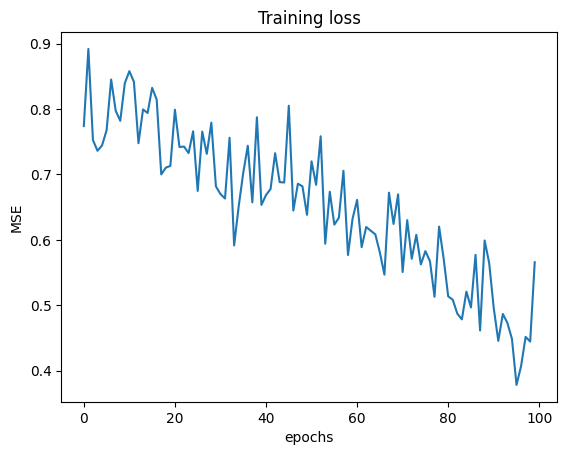

In [17]:
# plot the loss
plt.plot(losses)
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("Training loss")
plt.show()

In [18]:
# you can save the model here
#torch.save(model.state_dict(), "shallowPLRNN.pt")

In [19]:
# load pretrained model
model = shallowPLRNN(M=3, L=50, K=0)
model.load_state_dict(torch.load("pretrained-shPLRNN.pt"))

<All keys matched successfully>

# 7 Evaluation of the trained model
To evaluate the model, we will draw trajectories from the trained system and compare them to the ground truth test data. We will compute our DSR specific measures. We will also compute the maximum Lyapunov exponent and determine all dynamical objects.

### 7.1 Plot the orbit, evaluate measures

In [20]:
# lets draw an orbit of the system
x1 = torch.tensor(X_test[0, :])
orbit = generate_orbit(model, x1, T_test).numpy()

In [21]:
# use this to draw an orbit with external inputs
#orbit = generate_orbit(model, x1, T_test, dataset.S).numpy()

In [22]:
# compute the measures
D_H = power_spectrum_error(orbit, X_test, 20)
D_stsp = state_space_divergence_binning(orbit, X_test, 30)
print(f"D_H = {D_H}")
print(f"D_stsp = {D_stsp}")

D_H = 0.08072790765052558
D_stsp = 0.23329854011535645


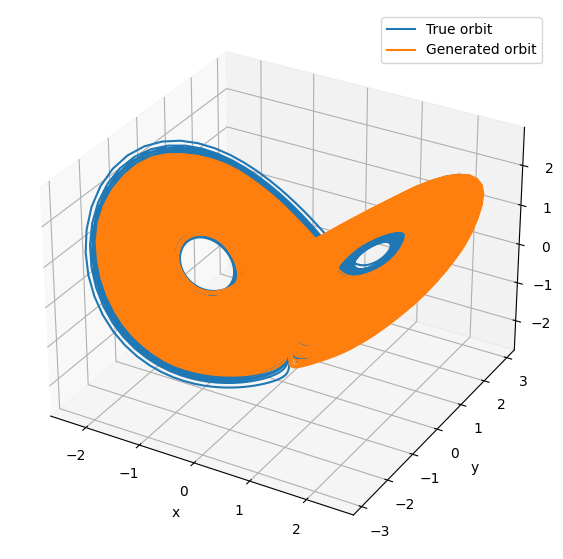

In [23]:
# plot orbit and ground truth attractor in state space
plt.figure(figsize=(12, 7))
ax = plt.axes(projection='3d')
ax.plot3D(X_test[:, 0], X_test[:, 1], X_test[:, 2], label="True orbit")
ax.plot3D(orbit[:, 0], orbit[:, 1], orbit[:, 2], label="Generated orbit")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()

### 7.2 Max. Lyapunov Exponent

The maximum Lyapunov exponent quantifies the divergence rate of nearby trajectories, and (for discrete time systems like the shPLRNN) is defined as
\begin{equation}
\lambda_{\text{max}} := \lim_{T \rightarrow \infty} \frac{1}{T}
\log \left\lVert \ \prod_{r=0}^{T-2} J_{T-r} \ \right\rVert_2,
\end{equation}
 where $J_t := \frac{\partial F_{\theta}\big(\mathbf{z}_{t-1}, \mathbf{s}_t \big)}{\partial\mathbf{z}_{t-1}} = \frac{\partial\mathbf{z}_t}{\partial\mathbf{z}_{t-1}},$ are the system's Jacobians and $\left\lVert\cdot\right\rVert_2$ is the spectral norm. To compute this quantity, the trained model is iterated until it reaches the attractor, and then the max. Lyapunov exponent is computed based on an additional $100,000$ time steps. For numerical stability, an algorithm which re-orthogonalizes the product series of Jacobians after every $n$-th time step using a QR decomposition, is used.

In [24]:
@torch.no_grad()
def max_lyapunov_exponent(model, T, z1, T_trans=1000, ons=1):

    # evolve for transient time Tₜᵣ
    X = generate_orbit(model, z1, T_trans)

    # initialize
    z = X[-1]
    lyap = 0
    # initialize as Identity matrix
    Q = torch.eye(model.M)

    for t in range(T):
        z=model(z)
        J = model.jacobian(z)
        Q = J @ Q

        if (t % ons == 0):

            # reorthogonalize
            Q, R = torch.linalg.qr(Q)

            # accumulate lyapunov exponents
            lyap += torch.log(torch.abs(R[0, 0])).item()

    return lyap / T

In [25]:
# determine the max. Lyapunov exponent. For comparison to the ground truth value, we divide by the sampling rate
# just to draw the Lorenz trajectories (\Delta t = 0.01)
max_LE = max_lyapunov_exponent(model=model, T=100000, z1=dataset.X[0, :], T_trans=10000, ons=10) / 0.01

In [26]:
# compare to the true value
rel_err = abs(max_LE - 0.906) / 0.906
print(f"Max. Lyapunov Exponent of the model generated attractor: {max_LE}")
print(f"Relative error compared to ground truth value: {round(rel_err*100, 3)}%")

Max. Lyapunov Exponent of the model generated attractor: 0.9047951901665802
Relative error compared to ground truth value: 0.133%


### 7.3 Computing Fixed Points of the Trained System

We are interested to see wheter we reconstructed the whole dynamical system including the FP's of the Lorenz63 system. For that we need to compute them. As discused before the beauty of the shallowPLRNN model is its analytical tractability which means that we have an analytical equation for calculating fixed points.

\begin{equation}
z^* = \biggl( \mathbb{1} - \bigl( A + W_1  D_{\Omega(t)} W_2)\biggl)^{-1} \biggl[W_1 D_{\Omega(t)} h_2 +h_1\biggl]
\end{equation}

where $D_{\Omega}= \text{diag} \big(d_{1}, d_{2}, \cdots, d_{L} \big)$ denotes an $L \times L$ diagonal binary indicator matrix representing the ReLU function of a specific linear subregion $\Omega$ at time step $t$ with $d_{l}=1$ if $\sum_{j=1}^{M} w^{(2)}_{lj} \,z_{j}> -h_{l}$ and $0$ otherwise.


To compute a FP we need to solve this equation for every subregion and if the solution $z^*$ lies in the same subregion $\Omega$  for which it was computed a real object has been found, otherwise we call the FP virtual.

For high-dimensional shallowPLRNNs it is not feasible to calculate this equations for every subregion $\Omega$ because of the the combinatorial explosion in their number (~$2^{dim}$). We therefore introduce an efficient search algorithm for finding all fixed points and cycles of a given shallowPLRNN, which we call $\textbf{S}$earcher for $\textbf{Cy}$cles and $\textbf{Fi}$xed points ($\textbf{SCYFI}$).

We discovered that the search becomes extremely efficient, without the need to exhaustively consider all configurations, if instead of randomly re-initializing the subregion in which we compute $z^*$ we initialize in the subregion of the last visited virtual FP.

With this simple heuristic we can efficiently calculate the dynamical objects of our shallowPLRNN.

We also have an expression for $n$-cycles:
\begin{equation}
z^{*n} =\bigg(\mathbb{1}- \prod_{i=1}^{n}\bigl( A + W_1  D_{\Omega (t^{*n}-i)} W_2\bigl) \bigg)^{-1} \times \bigg(\sum_{j=2}^{n} \Big[\prod_{i=1}^{n-j+1} \bigl( A + W_1  D_{\Omega (t^{*n}-i)} W_2\bigl) W_1 \, D_{\Omega(t^{*n}-n +j-2)} h_2 \Big]\ W_1 \,  D_{\Omega(t^{*n}-1)}  h_2
 \, + \, \Big(\sum_{j=2}^{n} \prod_{i=1}^{n-j+1} \bigl( A + W_1  D_{\Omega (t^{*n}-i)} W_2\bigl) + \mathbb{1} \Big) h_1 \bigg)
\end{equation}

but for now we will focus on computing fixed points.


Note that the paper containing this algorithm is currently under review.

In [27]:
def construct_relu_matrix(number_quadrant: int, dim: int):
    """
    Matrix describing the Relu function for different quadrants(subcompartments)
    """
    quadrant_index = format(number_quadrant, f'0{dim}b')[::-1]
    return np.diag(np.array([bool(int(bit)) for bit in quadrant_index]))

def construct_relu_matrix_list(dim: int, order: int):
    """
    Construct a list of relu matrices for a random sequence of quadrants
    """
    relu_matrix_list = np.empty((dim, dim, order))
    for i in range(order):
        n = int(np.floor(np.random.rand(1)[0] * (2 ** dim)))
        relu_matrix_list[:, :, i] = construct_relu_matrix(n, dim)
    return relu_matrix_list

def get_cycle_point_candidate(A, W1, W2, h1, h2, D_list, order):
    """
    get the candidate for a cycle point by solving the cycle equation
    """
    z_factor, h1_factor, h2_factor = get_factors(A, W1, W2, D_list, order)
    try:
        inverse_matrix = np.linalg.inv(np.eye(A.shape[0]) - z_factor)
        z_candidate = inverse_matrix.dot(h1_factor.dot(h1) + h2_factor.dot(h2))
        return z_candidate
    except np.linalg.LinAlgError:
        # Not invertible
        return None

def get_factors(A, W1, W2, D_list, order):
    """
    recursively applying map gives us the factors of the cycle equation
    """
    hidden_dim = W2.shape[0]
    latent_dim = W1.shape[0]
    factor_z = np.eye(A.shape[0])
    factor_h1 = np.eye(A.shape[0])
    factor_h2 = W1.dot(D_list[:, :, 0]).dot(np.eye(hidden_dim))
    for i in range(order - 1):
        factor_z = (A + W1.dot(D_list[:, :, i]).dot(W2)).dot(factor_z)
        factor_h1 = (A + W1.dot(D_list[:, :, i + 1]).dot(W2)).dot(factor_h1) + np.eye(A.shape[0])
        factor_h2 = (A + W1.dot(D_list[:, :, i + 1]).dot(W2)).dot(factor_h2) + W1.dot(D_list[:, :, i + 1])
    factor_z = (A + W1.dot(D_list[:, :, order-1]).dot(W2)).dot(factor_z)
    return factor_z, factor_h1, factor_h2

def get_latent_time_series(time_steps, A, W1, W2, h1, h2, dz, z_0=None):
    """
    Generate the time series by iteravely applying the PLRNN
    """
    if z_0 is None:
        z = np.random.randn(dz)
    else:
        z = z_0
    trajectory = [z]

    for t in range(1, time_steps):
        z = latent_step(z, A, W1, W2, h1, h2)
        trajectory.append(z)
    return trajectory

def latent_step(z, A, W1, W2, h1, h2):
    """
    PLRNN step
    """
    return A.dot(z) + W1.dot(np.maximum(W2.dot(z) + h2, 0)) + h1

def get_eigvals(A, W1, W2, D_list, order):
    """
    Get the eigenvalues for all the points along the trajectory to learn about the stability
    """
    e = np.eye(A.shape[0])
    for i in range(order):
        e = (np.diag(A) + W1.dot(D_list[:, :, i]).dot(W2)).dot(e)
    return np.linalg.eigvals(e)

In [28]:
def scy_fi(A, W1, W2, h1, h2, order, found_lower_orders, outer_loop_iterations=300, inner_loop_iterations=100):
    """
    heuristic algorithm for calculating FP/k-cycle
    """
    hidden_dim = h2.shape[0]
    latent_dim = h1.shape[0]
    cycles_found = []
    eigvals = []

    i = -1
    while i < outer_loop_iterations:
        i += 1
        relu_matrix_list = construct_relu_matrix_list(hidden_dim, order)
        difference_relu_matrices = 1
        c = 0
        while c < inner_loop_iterations:
            c += 1
            z_candidate = get_cycle_point_candidate(A, W1, W2, h1, h2, relu_matrix_list, order)
            if z_candidate is not None:
                trajectory = get_latent_time_series(order, A, W1, W2, h1, h2, latent_dim, z_0=z_candidate)
                trajectory_relu_matrix_list = np.empty((hidden_dim, hidden_dim, order))
                for j in range(order):
                    trajectory_relu_matrix_list[:, :, j] = np.diag((W2.dot(trajectory[j]) + h2) > 0)
                for j in range(order):
                    difference_relu_matrices = np.sum(np.abs(trajectory_relu_matrix_list[:, :, j] - relu_matrix_list[:, :, j]))
                    if difference_relu_matrices != 0:
                        break
                    if found_lower_orders:
                        if np.round(trajectory[0], decimals=2) in np.round(np.array(found_lower_orders).flatten(), decimals=2):
                            difference_relu_matrices = 1
                            break
                if difference_relu_matrices == 0:
                    if not np.any(np.isin(np.round(trajectory[0], 2), np.round(cycles_found, 2))):
                        e = get_eigvals(A, W1, W2, relu_matrix_list, order)
                        cycles_found.append(trajectory)
                        eigvals.append(e)
                        i = 0
                        c = 0
                if np.array_equal(relu_matrix_list, trajectory_relu_matrix_list):
                    relu_matrix_list = construct_relu_matrix_list(hidden_dim, order)
                else:
                    relu_matrix_list = trajectory_relu_matrix_list
            else:
                relu_matrix_list = construct_relu_matrix_list(hidden_dim, order)
    return cycles_found, eigvals

In [29]:
def main(A, W1, W2, h1, h2, order, outer_loop_iterations=None, inner_loop_iterations=None):
    found_lower_orders = []
    found_eigvals = []

    for i in range(1, order + 1):
        cycles_found, eigvals = scy_fi(A, W1, W2, h1, h2, i, found_lower_orders, outer_loop_iterations=outer_loop_iterations, inner_loop_iterations=inner_loop_iterations)

        found_lower_orders.append(cycles_found)
        found_eigvals.append(eigvals)

    return [found_lower_orders, found_eigvals]

In [30]:
A = model.A.detach().numpy()
W1 = model.W1.detach().numpy()
W2 = model.W2.detach().numpy()
h1 = model.h1.detach().numpy()
h2 = model.h2.detach().numpy()

dyn_objects, eigenvals = main(np.diag(A), W1, W2, h1, h2, 1, outer_loop_iterations=30, inner_loop_iterations=10)

dyn_objects

[[[array([-0.96366273, -0.85881816,  0.37466773])],
  [array([1.1684331 , 1.0304688 , 0.49788003])],
  [array([ 0.07166251,  0.081578  , -2.58943431])]]]

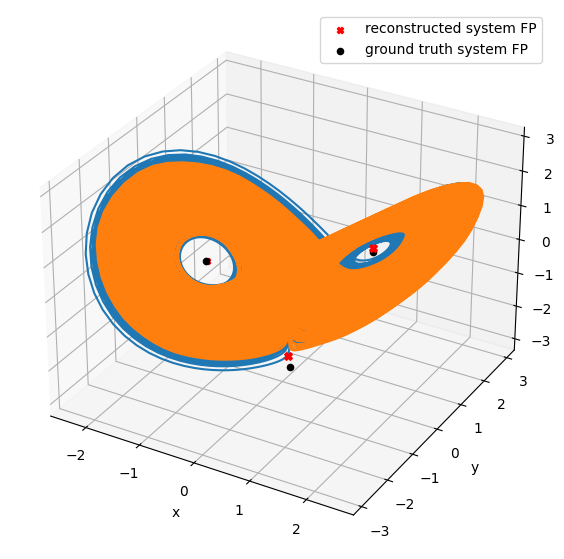

In [31]:
ax = plt.figure(figsize=(12, 7)).add_subplot(projection='3d')
ax.plot(X_test[:, 0], X_test[:, 1], X_test[:, 2])
ax.plot(orbit[:, 0], orbit[:, 1], orbit[:, 2])

# Scatter plot for FP
ax.scatter(dyn_objects[0][0][0][0], dyn_objects[0][0][0][1], dyn_objects[0][0][0][2],marker="X",c="red",label="reconstructed system FP")
ax.scatter(dyn_objects[0][1][0][0], dyn_objects[0][1][0][1],dyn_objects[0][1][0][2],marker="X",s=30,c="red")
ax.scatter(dyn_objects[0][2][0][0], dyn_objects[0][2][0][1], dyn_objects[0][2][0][2],marker="X",s=30,c="red")



# Scatter plot for ground truth points
true_FPs = np.load("lorenz63_standardized_FPs.npy")
ax.scatter(true_FPs[0, 0], true_FPs[1, 0], true_FPs[2, 0], c="black",label="ground truth system FP")
ax.scatter(true_FPs[0, 1], true_FPs[1, 1], true_FPs[2, 1], c="black")
ax.scatter(true_FPs[0, 2], true_FPs[1, 2], true_FPs[2, 2], c="black")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()
plt.show()

In [32]:
if max(abs(eigenvals[0][0])) >1:
  print("FP 1: max eigenvalue", max(abs(eigenvals[0][0])),">1: FP is unstable")
else:
  print("FP 1: max eigenvalue", max(abs(eigenvals[0][0])),"<1: FP is stable")
if max(abs(eigenvals[0][1])) >1:
  print("FP 2: max eigenvalue", max(abs(eigenvals[0][1])),">1: FP is unstable")
else:
  print("FP 2: max eigenvalue", max(abs(eigenvals[0][1])),"<1: FP is stable")
if max(abs(eigenvals[0][2])) >1:
  print("FP 3: max eigenvalue", max(abs(eigenvals[0][2])),">1: FP is unstable")
else:
  print("FP 3: max eigenvalue", max(abs(eigenvals[0][2])),"<1: FP is stable")


FP 1: max eigenvalue 2.452627054923573 >1: FP is unstable
FP 2: max eigenvalue 2.492473740944646 >1: FP is unstable
FP 3: max eigenvalue 2.543892724812008 >1: FP is unstable
